# Import the KA and climate data 

In [39]:
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load datasets
kal_data = pd.read_excel('/Users/berhe/Desktop/ka-project/KA_linelist/ll_ka.xlsx')                            # Linelist data 
climate_data = pd.read_csv('/Users/berhe/Desktop/ka-project/Temp-rain-humid/NASA-Temp-perc-humid.csv')         # Rainfall data can e dropped
ndvi_data_16d = pd.read_csv('/Users/berhe/Desktop/ka-project/NDVI_Dataset/MODIS_NDVI_Lankien.csv')              # biweekly NDVI data                     
lst_data = pd.read_csv('/Users/berhe/Desktop/ka-project/MODIS_LST_Dataset/MODIS_LST_Lankien.csv')                # land surface temprature 
perc_data =pd.read_csv('/Users/berhe/Desktop/ka-project/Precipitation_Data/SPI_Lankien.csv')                      # better quality
soil_mois_data =pd.read_csv('/Users/berhe/Desktop/ka-project/soil_moisture_data.csv')
radiation_data =pd.read_csv('/Users/berhe/Desktop/ka-project/Solar_radiation_Dataset/radiation_Lankien.csv')
wind_data =pd.read_csv('/Users/berhe/Desktop/ka-project/Wind_Data_Dataset/wind_Lankien_20250304.csv')
ndvi_data_5d =pd.read_csv('/Users/berhe/Desktop/ka-project/NDVI_Dataset/fiveday_NDVI_Lankien.csv')
evi_data_16d =pd.read_csv('/Users/berhe/Desktop/ka-project/EVI/EVI_16day_Lankien.csv')
flood_cover = pd.read_csv("flood_cover/lankien_flood_timeseries_2015_2024.csv")

# Flood cover data 
flood_cover["date"] = pd.to_datetime(flood_cover["date"]).dt.date
flood_cover["date"] = pd.to_datetime(flood_cover["date"])

# keep only the maximumof the flooded_area_m2 value

flood_cover = flood_cover.groupby("date", as_index=False).max()


# rename the 5d NDVI column to NDVI_5d
ndvi_data_5d.rename(columns={"NDVI": "NDVI_5d"}, inplace=True)

# Convert date columns
kal_data["date"] = pd.to_datetime(kal_data["date"])
climate_data["date"] = pd.to_datetime(climate_data["date"])
ndvi_data_16d["Date"] = pd.to_datetime(ndvi_data_16d["Date"])
lst_data["Date"] =pd.to_datetime(lst_data["Date"])
perc_data["Date"] =pd.to_datetime(perc_data["Date"])
soil_mois_data["Date"] =pd.to_datetime(soil_mois_data["Date"])
radiation_data["date"] =pd.to_datetime(radiation_data["date"])
wind_data["date"] =pd.to_datetime(wind_data["date"])
ndvi_data_5d["Date"] =pd.to_datetime(ndvi_data_5d["Date"])
evi_data_16d["date"] =pd.to_datetime(evi_data_16d["date"])

# Rename NDVI date column to match others
ndvi_data_16d.rename(columns={"Date": "date"}, inplace=True)
ndvi_data_5d.rename(columns={"Date": "date"}, inplace=True)
lst_data.rename(columns={"Date": "date"}, inplace=True)
perc_data.rename(columns={"Date": "date"}, inplace=True)
soil_mois_data.rename(columns={"Date": "date"}, inplace=True)

# Aggregate KA cases per day
ka_cases_daily = kal_data.groupby("date").size().reset_index(name="ka_cases")

# Merge datasets
merged_df = pd.merge(ka_cases_daily, climate_data, on= "date", how = "right")
merged_df = merged_df.merge(ndvi_data_16d, on="date", how= "left")                # Left join keeps all climate data
merged_df = merged_df.merge(ndvi_data_5d, on="date", how= "left")                # Left join keeps all climate data
merged_df =merged_df.merge(lst_data, on = "date", how = "left")
merged_df =merged_df.merge(perc_data, on = "date", how = "left")
merged_df =merged_df.merge(soil_mois_data, on = "date", how = "left")
merged_df =merged_df.merge(radiation_data, on = "date", how = "left")
merged_df =merged_df.merge(wind_data, on = "date", how = "left")
merged_df =merged_df.merge(evi_data_16d, on = "date", how = "left")
merged_df =merged_df.merge(flood_cover, on = "date", how = "left")


# handle the missing values

merged_df["ka_cases"].fillna(0, inplace=True)
merged_df["NDVI"] = merged_df["NDVI"].fillna(method="ffill")
merged_df["Precipitation"] = merged_df["Precipitation"].fillna(method="ffill")
merged_df["SPI"] = merged_df["SPI"].fillna(method="ffill")
merged_df["LST_Day_1km"] = merged_df["LST_Day_1km"].fillna(method="ffill")
merged_df["humidity"] = merged_df["humidity"].fillna(method="ffill")
merged_df["Soil_Moisture"] = merged_df["Soil_Moisture"].fillna(method="ffill")
merged_df["NDVI_5d"] = merged_df["NDVI_5d"].fillna(method="ffill")
merged_df["EVI"] = merged_df["EVI"].fillna(method="ffill")
merged_df["flooded_area_m2"] = merged_df["flooded_area_m2"].fillna(method="ffill")

# Drop rows where 'LST_Day_1km' is missing
merged_df = merged_df.dropna(subset=["LST_Day_1km"])
merged_df = merged_df.dropna(subset=["Soil_Moisture"])
merged_df = merged_df.dropna(subset=["NDVI_5d"])

# filter data to only the period where we have KA cases

# Filter for dates greater than or equal to 2015-11-01
merged_df = merged_df[merged_df["date"] >= "2015-11-01"]
merged_df = merged_df[merged_df["date"] <= "2022-04-05"]

# Display the first few rows of the merged dataset
merged_df.head()

# Check if there are still any missing values
print(merged_df.isnull().sum())

# Feature selection
features = ["temp_mean", "temp_min", "temp_max", "humidity", "NDVI", "NDVI_5d", "Precipitation", "SPI", "LST_Day_1km", "Soil_Moisture", "solar_radiation", "wind_speed_10m", "wind_direction_10m","wind_speed_50m", "wind_direction_50m"]
X = merged_df[features]
y = merged_df["ka_cases"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# save the data 

merged_df.to_csv("merged_df_flood.csv")
flood_cover.to_csv("flood_cover_clean.csv")

date                  0
ka_cases              0
temp_mean             0
temp_min              0
temp_max              0
rainfall              0
humidity              0
NDVI                  0
NDVI_5d               0
LST_Day_1km           0
Precipitation         0
SPI                   0
Soil_Moisture         0
solar_radiation       0
wind_speed_10m        0
wind_direction_10m    0
wind_speed_50m        0
wind_direction_50m    0
EVI                   0
flooded_area_m2       0
dtype: int64


## Flood data

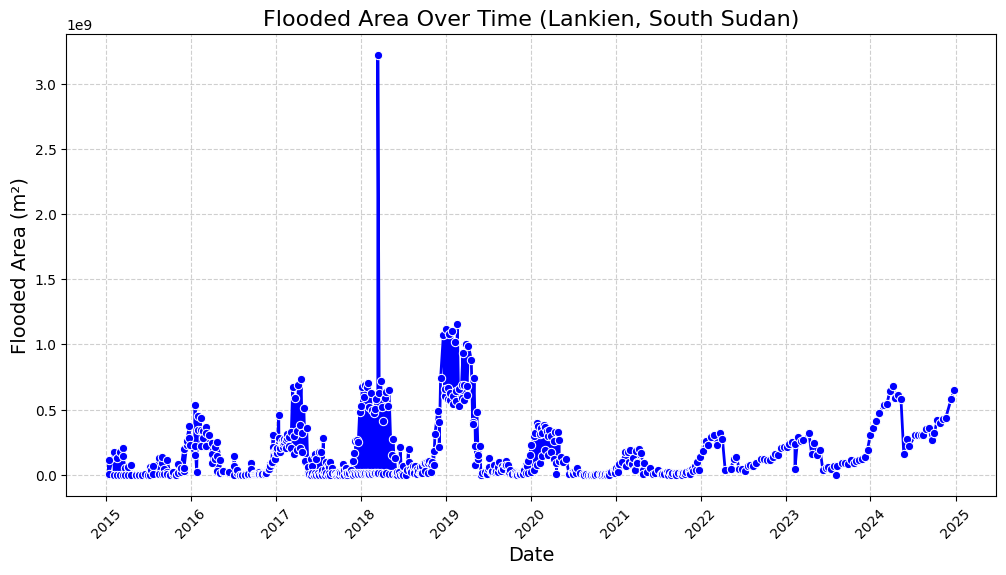

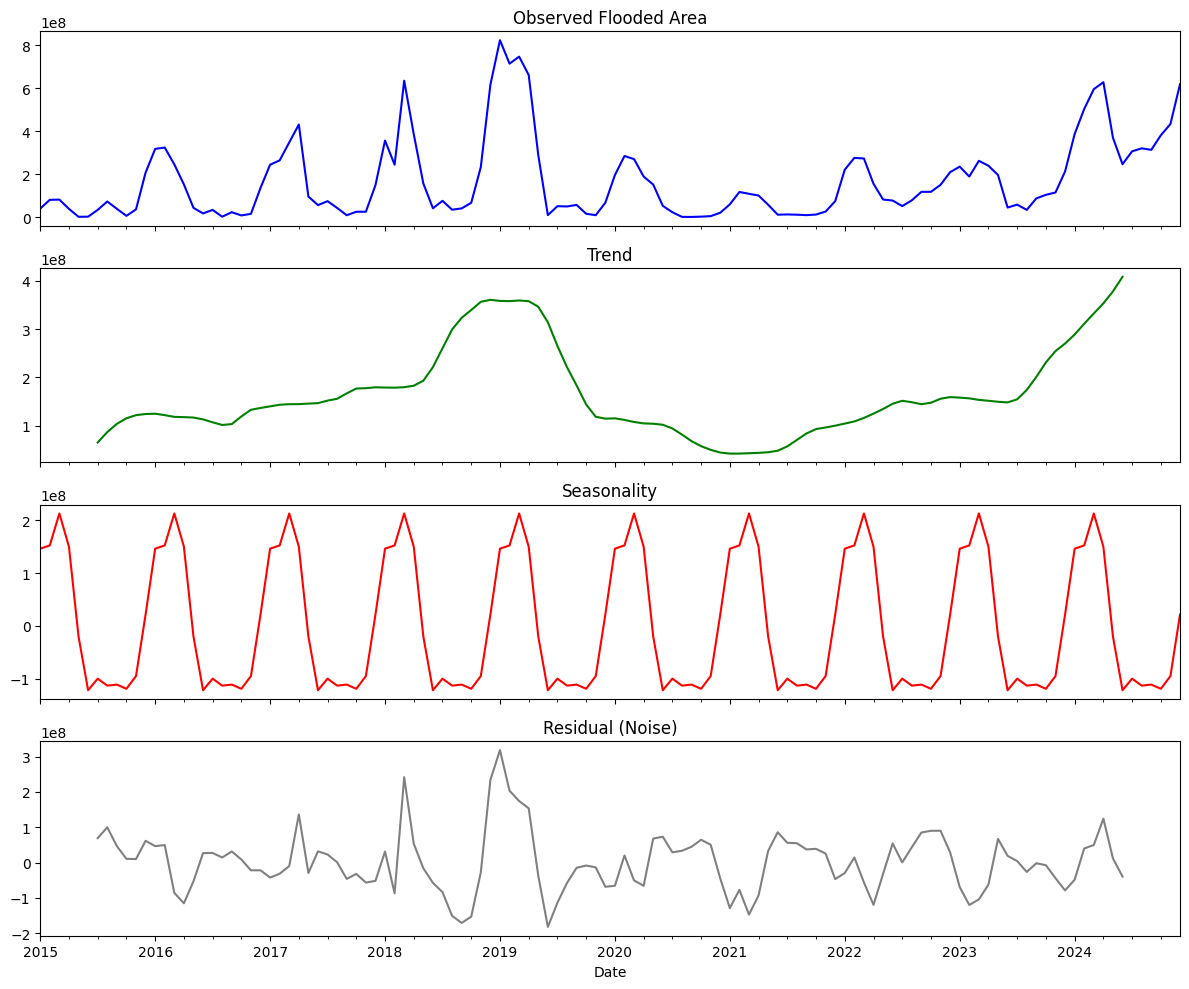

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the merged flood time series data
df = pd.read_csv("flood_cover/lankien_flood_timeseries_2015_2024.csv")

# Convert date column to datetime format
df["date"] = pd.to_datetime(df["date"])

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(x="date", y="flooded_area_m2", data=df, marker="o", color="blue", linewidth=2)

# Formatting
plt.xlabel("Date", fontsize=14)
plt.ylabel("Flooded Area (m²)", fontsize=14)
plt.title("Flooded Area Over Time (Lankien, South Sudan)", fontsize=16)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()

####

df.set_index("date", inplace=True)

# Resample data to monthly frequency (if daily data is too sparse)
df_monthly = df.resample("M").mean()

# Decompose time series (Additive or Multiplicative Model)
decomposition = seasonal_decompose(df_monthly["flooded_area_m2"], model="additive", period=12)

# Plot decomposition results
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

decomposition.observed.plot(ax=axes[0], title="Observed Flooded Area", color="blue")
decomposition.trend.plot(ax=axes[1], title="Trend", color="green")
decomposition.seasonal.plot(ax=axes[2], title="Seasonality", color="red")
decomposition.resid.plot(ax=axes[3], title="Residual (Noise)", color="gray")

plt.xlabel("Date")
plt.tight_layout()
plt.show()


# How VV Works in Flood Detection

Lower VV values indicate water because water surfaces reflect the radar signal away from the sensor, reducing backscatter.
Higher VV values indicate land (vegetation, buildings, dry ground) due to stronger radar returns.
If we used VV < -18 for water detection, the flood mask should correctly highlight flooded areas.

## Flooded area map comparison 

In [41]:
import ee
import geemap

# Initialize Earth Engine
ee.Initialize(project="gee-ndvi-berhe")

# Define Area of Interest (South Sudan Bounding Box)
aoi = ee.Geometry.Rectangle([30.957, 7.480, 32.008, 9.205])

# Function to get Sentinel-1 flood mask
def get_flood_mask(start_date, end_date):
    sentinel1 = (
        ee.ImageCollection("COPERNICUS/S1_GRD")
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV"))
        .select("VV")
        .mean()
    )
    flood_mask = sentinel1.lt(-18)  # Threshold for flood detection
    return flood_mask

# Get Flood Masks for 2015 and 2022
flood_2015 =get_flood_mask("2015-01-01", "2015-12-31")
flood_2016 =get_flood_mask("2016-01-01", "2016-12-31")
flood_2017 =get_flood_mask("2017-01-01", "2017-12-31")
flood_2018 = get_flood_mask("2018-01-01", "2018-12-31")
flood_2019 = get_flood_mask("2019-01-01", "2019-12-31")
flood_2020 = get_flood_mask("2020-01-01", "2020-12-31")
flood_2021 = get_flood_mask("2021-01-01", "2021-12-31")

# Create Map
Map = geemap.Map()
Map.centerObject(aoi, 7)

Map.addLayer(flood_2015.selfMask(), {"palette": "yellow"}, "Flooded Area 2015")
Map.addLayer(flood_2016.selfMask(), {"palette": "green1"}, "Flooded Area 2016")
Map.addLayer(flood_2017.selfMask(), {"palette": "grey"}, "Flooded Area 2017")
Map.addLayer(flood_2018.selfMask(), {"palette": "blue"}, "Flooded Area 2018")
Map.addLayer(flood_2019.selfMask(), {"palette": "grey45"}, "Flooded Area 2019")
Map.addLayer(flood_2020.selfMask(), {"palette": "red"}, "Flooded Area 2020")
Map.addLayer(flood_2021.selfMask(), {"palette": "pink"}, "Flooded Area 2021")

# Display Map
Map


The provided color (green1) is invalid. Using the default black color.
'#green1' is not in web format. Need 3 or 6 hex digit.
The provided color (grey45) is invalid. Using the default black color.
'#grey45' is not in web format. Need 3 or 6 hex digit.


Map(center=[8.342211128604346, 31.482500000000076], controls=(WidgetControl(options=['position', 'transparent_…

## Corelation analysis 

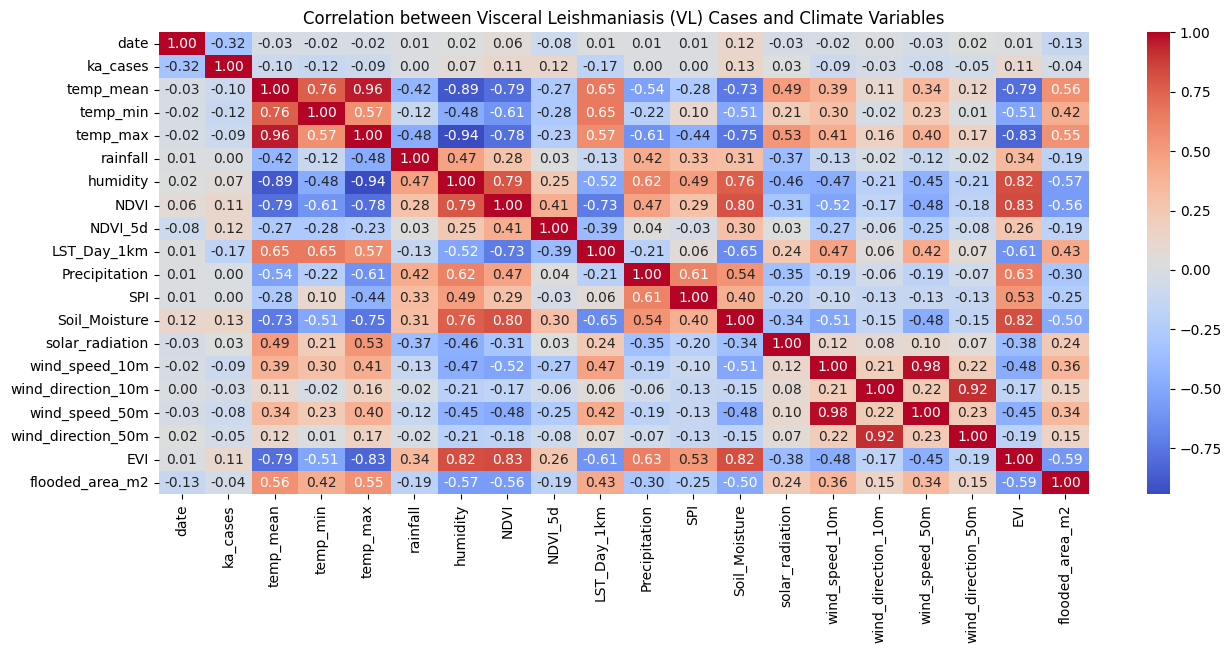

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(merged_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Visceral Leishmaniasis (VL) Cases and Climate Variables")
plt.show()


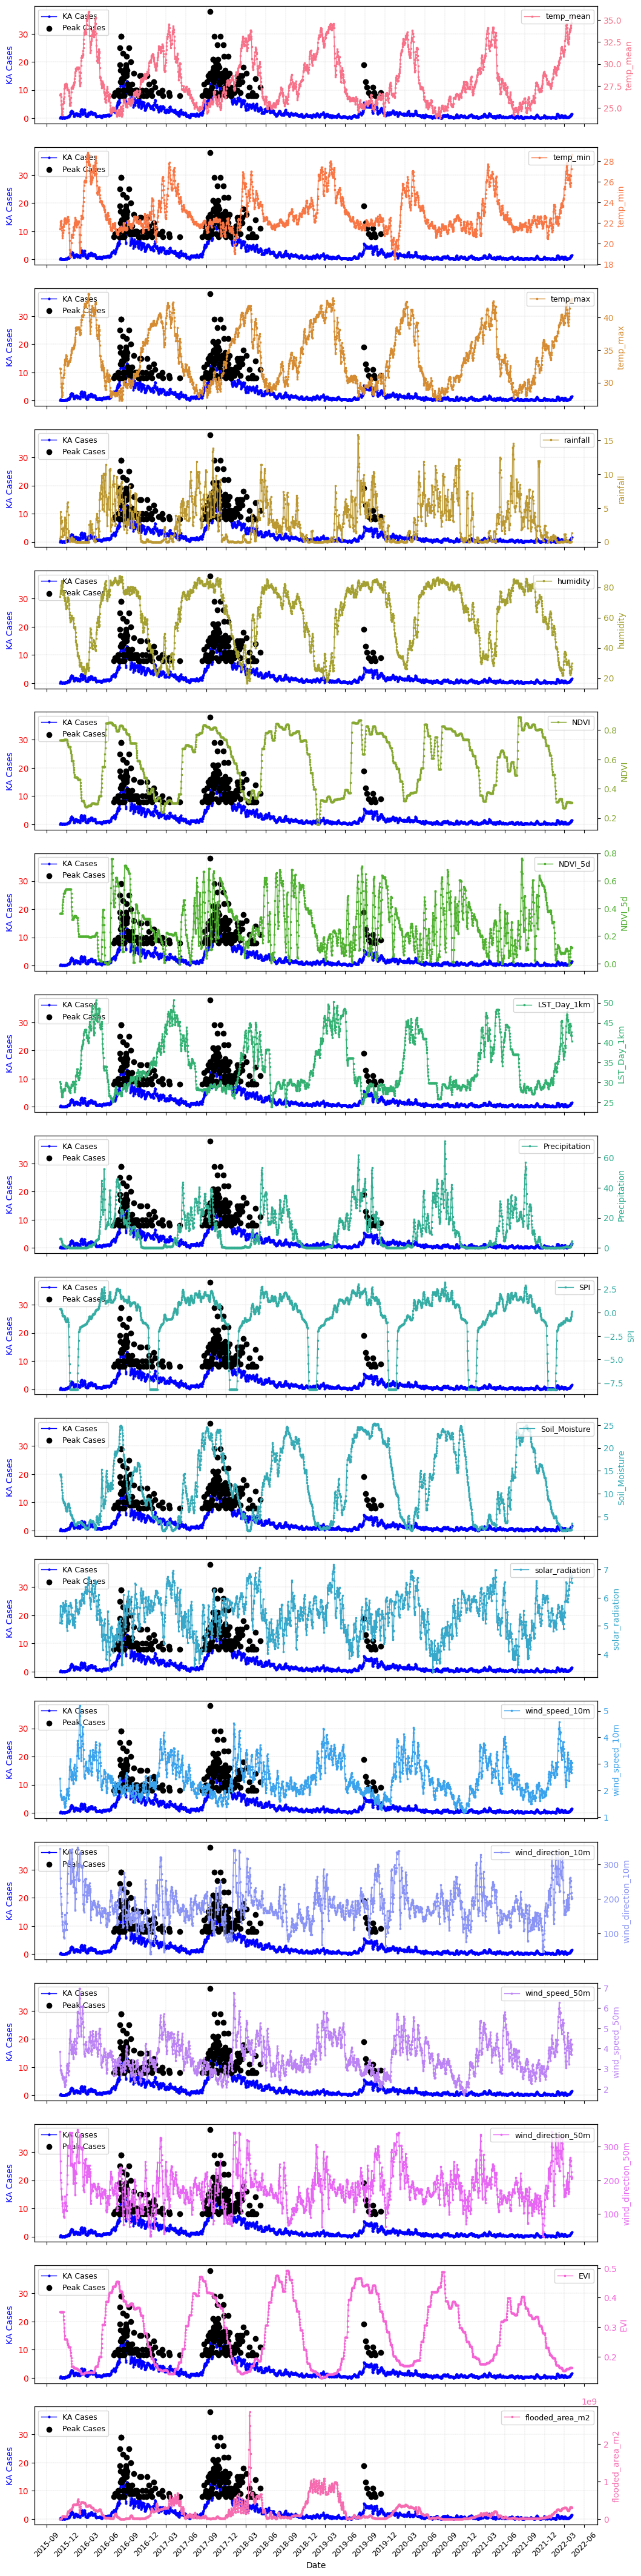

<Figure size 2000x400 with 0 Axes>

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure 'date' column is in datetime format
merged_df["date"] = pd.to_datetime(merged_df["date"])

# Define the climate indicators (excluding KA_cases itself)
climate_vars = [col for col in merged_df.columns if col not in ["date", "ka_cases"]]

# Number of subplots needed
num_vars = len(climate_vars)

# Create subplots with shared x-axis
fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(12, 3 * num_vars), sharex=True)

# Ensure axes is iterable (even when there's only one variable)
if num_vars == 1:
    axes = [axes]

# Generate a color palette for better differentiation
colors = sns.color_palette("husl", len(climate_vars))

# Rolling window for smoothing trends
rolling_window = 7  

# Iterate over each climate variable and pair with KA_cases
for i, col in enumerate(climate_vars):
    ax1 = axes[i]
    
    # Apply rolling mean smoothing
    merged_df["ka_cases_smooth"] = merged_df["ka_cases"].rolling(rolling_window, min_periods=1).mean()
    merged_df[col + "_smooth"] = merged_df[col].rolling(rolling_window, min_periods=1).mean()

    # Plot KA_cases on left y-axis
    ax1.plot(merged_df["date"], merged_df["ka_cases_smooth"], label="KA Cases", color="blue", 
             marker='o', markersize=2, linestyle='-', linewidth=1)
    ax1.set_ylabel("KA Cases", fontsize=10, color="blue")
    ax1.tick_params(axis='y', labelcolor="red")
    
    # Highlight peaks in KA Cases
    peak_threshold = merged_df["ka_cases"].quantile(0.9)  # Adjust threshold if needed
    peaks = merged_df[merged_df["ka_cases"] > peak_threshold]
    ax1.scatter(peaks["date"], peaks["ka_cases"], color="black", label="Peak Cases", zorder=3)

    # Create a secondary y-axis for climate variable
    ax2 = ax1.twinx()
    ax2.plot(merged_df["date"], merged_df[col + "_smooth"], label=col, color=colors[i], 
             marker='s', markersize=2, linestyle='-', linewidth=1)
    ax2.set_ylabel(col, fontsize=10, color=colors[i])
    ax2.tick_params(axis='y', labelcolor=colors[i])

    # Grid and legend
    ax1.grid(True, linestyle="--", linewidth=0.2)
    ax1.legend(loc="upper left", fontsize=9)
    ax2.legend(loc="upper right", fontsize=9)

    # Format x-axis to show every 3 months
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.tick_params(axis='x', rotation=45, labelsize=9)

# Set common x-axis label
axes[-1].set_xlabel("Date", fontsize=10)

# Adjust layout for better spacing
plt.figure(figsize=(20, 4))
plt.suptitle("KA Cases vs Climate Indicators Over Time in Lankien, South Sudan", fontsize=14, y=0.89)
plt.subplots_adjust(hspace=0.3)
plt.show()


# Remove redenduncy 

In [45]:
merged_df.drop(columns=["EVI","rainfall", "humidity", "temp_min", "temp_mean", "Soil_Moisture","wind_direction_50m", "wind_speed_50m" ], inplace=True)

In [46]:
print(merged_df.columns)

Index(['date', 'ka_cases', 'temp_max', 'NDVI', 'NDVI_5d', 'LST_Day_1km',
       'Precipitation', 'SPI', 'solar_radiation', 'wind_speed_10m',
       'wind_direction_10m', 'flooded_area_m2', 'ka_cases_smooth',
       'temp_mean_smooth', 'temp_min_smooth', 'temp_max_smooth',
       'rainfall_smooth', 'humidity_smooth', 'NDVI_smooth', 'NDVI_5d_smooth',
       'LST_Day_1km_smooth', 'Precipitation_smooth', 'SPI_smooth',
       'Soil_Moisture_smooth', 'solar_radiation_smooth',
       'wind_speed_10m_smooth', 'wind_direction_10m_smooth',
       'wind_speed_50m_smooth', 'wind_direction_50m_smooth', 'EVI_smooth',
       'flooded_area_m2_smooth'],
      dtype='object')


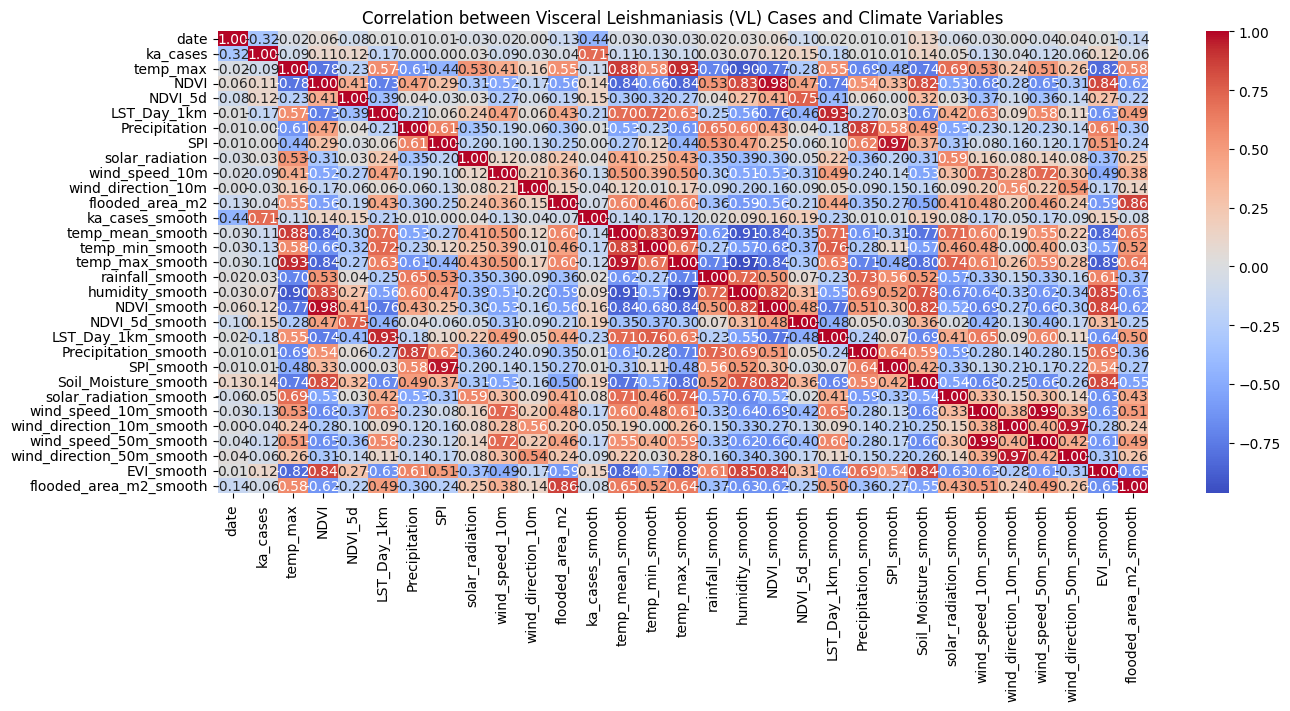

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(merged_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Visceral Leishmaniasis (VL) Cases and Climate Variables")
plt.show()


## Time series plot of KA cases and climate indicators 

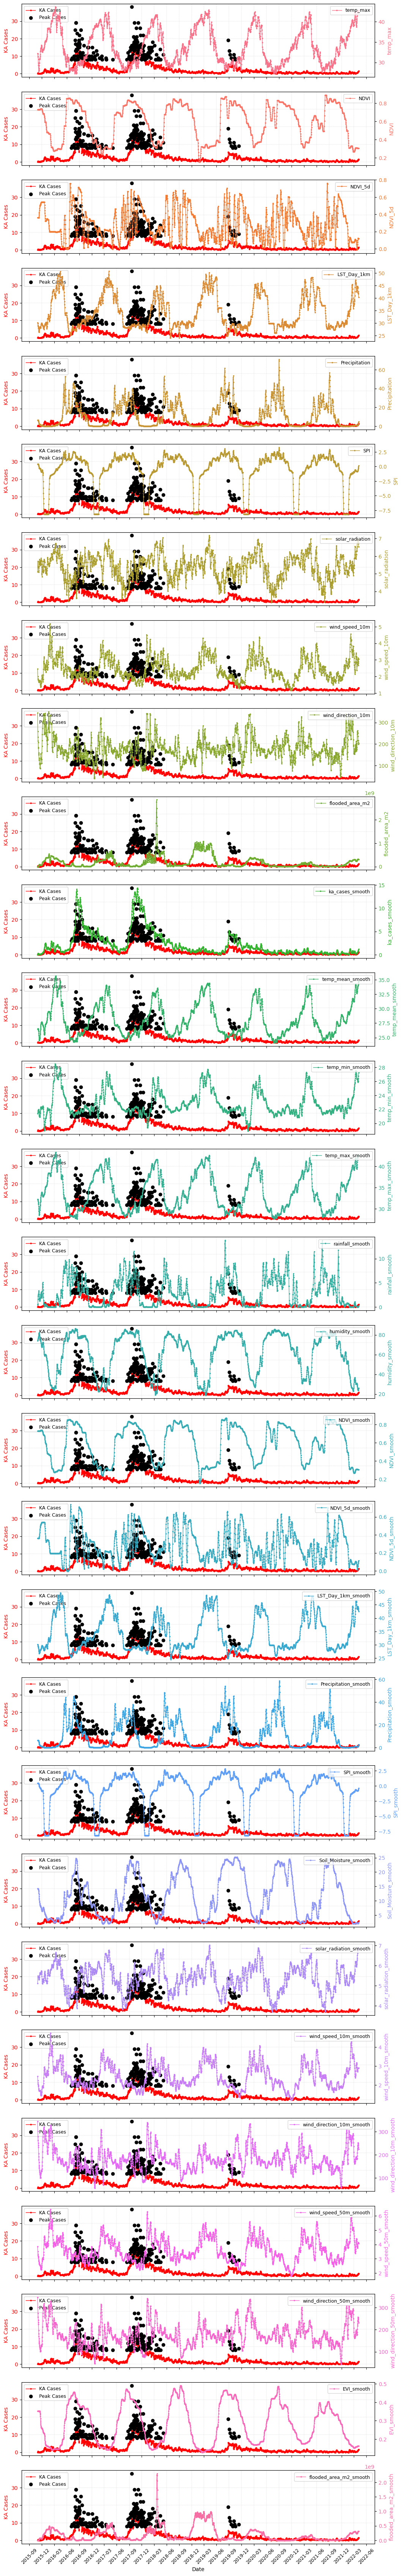

<Figure size 1500x400 with 0 Axes>

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure 'date' column is in datetime format
merged_df["date"] = pd.to_datetime(merged_df["date"])

# Define the climate indicators (excluding KA_cases itself)
climate_vars = [col for col in merged_df.columns if col not in ["date", "ka_cases"]]

# Number of subplots needed
num_vars = len(climate_vars)

# Create subplots with shared x-axis
fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(12, 3 * num_vars), sharex=True)

# Ensure axes is iterable (even when there's only one variable)
if num_vars == 1:
    axes = [axes]

# Generate a color palette for better differentiation
colors = sns.color_palette("husl", len(climate_vars))

# Rolling window for smoothing trends
rolling_window = 7  

# Iterate over each climate variable and pair with KA_cases
for i, col in enumerate(climate_vars):
    ax1 = axes[i]
    
    # Apply rolling mean smoothing
    merged_df["ka_cases_smooth"] = merged_df["ka_cases"].rolling(rolling_window, min_periods=1).mean()
    merged_df[col + "_smooth"] = merged_df[col].rolling(rolling_window, min_periods=1).mean()

    # Plot KA_cases on left y-axis
    ax1.plot(merged_df["date"], merged_df["ka_cases_smooth"], label="KA Cases", color="red", 
             marker='o', markersize=2, linestyle='-', linewidth=1)
    ax1.set_ylabel("KA Cases", fontsize=10, color="red")
    ax1.tick_params(axis='y', labelcolor="red")
    
    # Highlight peaks in KA Cases
    peak_threshold = merged_df["ka_cases"].quantile(0.9)  # Adjust threshold if needed
    peaks = merged_df[merged_df["ka_cases"] > peak_threshold]
    ax1.scatter(peaks["date"], peaks["ka_cases"], color="black", label="Peak Cases", zorder=3)

    # Create a secondary y-axis for climate variable
    ax2 = ax1.twinx()
    ax2.plot(merged_df["date"], merged_df[col + "_smooth"], label=col, color=colors[i], 
             marker='s', markersize=2, linestyle='-', linewidth=1)
    ax2.set_ylabel(col, fontsize=10, color=colors[i])
    ax2.tick_params(axis='y', labelcolor=colors[i])

    # Grid and legend
    ax1.grid(True, linestyle="--", linewidth=0.2)
    ax1.legend(loc="upper left", fontsize=9)
    ax2.legend(loc="upper right", fontsize=9)

    # Format x-axis to show every 3 months
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.tick_params(axis='x', rotation=45, labelsize=9)

# Set common x-axis label
axes[-1].set_xlabel("Date", fontsize=10)

# Adjust layout for better spacing
plt.figure(figsize=(15, 4))
plt.suptitle("KA Cases vs Climate Indicators Over Time in Lankien, South Sudan", fontsize=14, y=0.89)
plt.subplots_adjust(hspace=0.3)
plt.show()


## Lagged corelation analysis

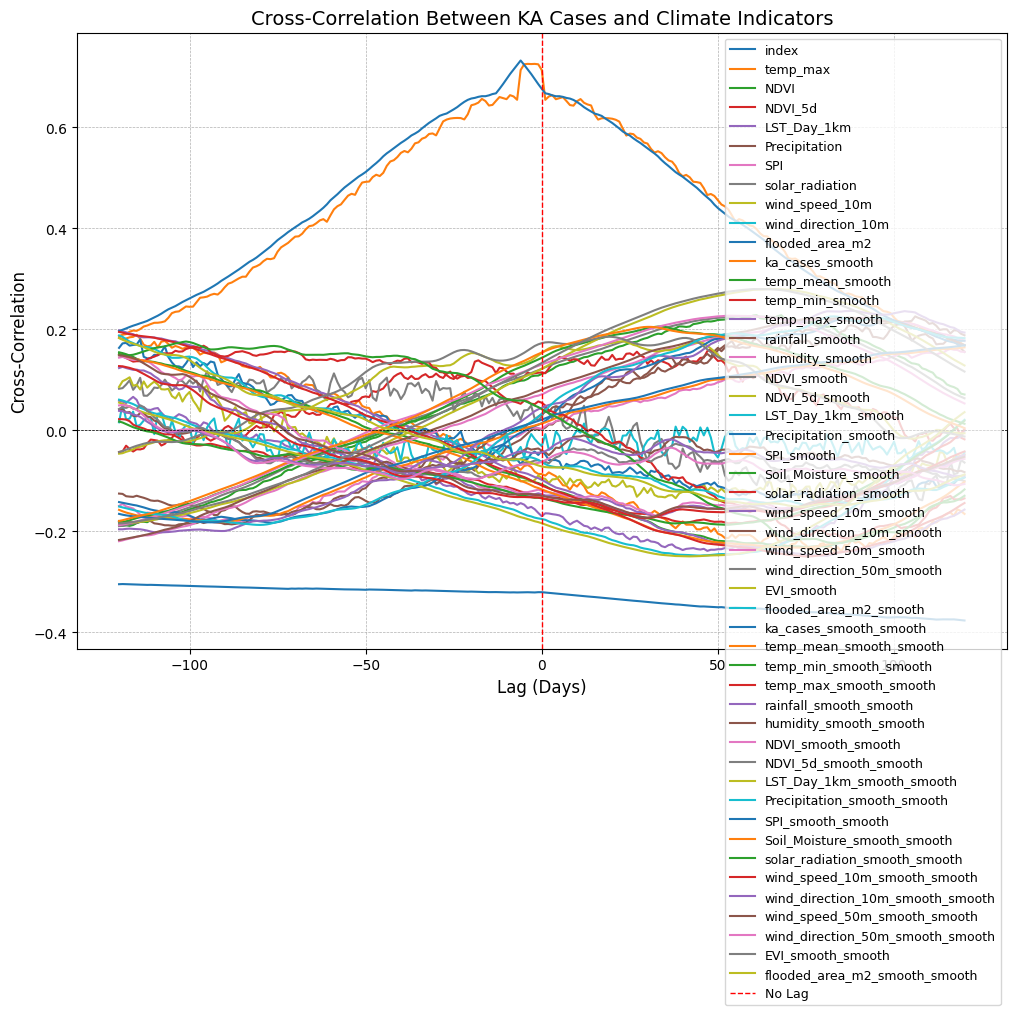

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import correlate

# Ensure date is a datetime index
merged_df.reset_index(inplace=True)  # This restores "date" as a column
merged_df["date"] = pd.to_datetime(merged_df["date"])  # Ensure it's in datetime format
merged_df.set_index("date", inplace=True)  # Set it back as index


# Fill missing values (linear interpolation)
merged_df = merged_df.interpolate()

# Normalize KA cases and climate variables
merged_df_normalized = (merged_df - merged_df.mean()) / merged_df.std()

# Define the KA case time series
ka_cases_series = merged_df_normalized["ka_cases"]

# Define climate variables to analyze
climate_vars = [col for col in merged_df_normalized.columns if col != "ka_cases"]

# Set max lag in days (e.g., ±90 days)
max_lag = 120
lags = np.arange(-max_lag, max_lag + 1)

# Create a figure for visualization
plt.figure(figsize=(12, 8))

for col in climate_vars:
    # Compute cross-correlation using NumPy correlate function
    cross_corr = [ka_cases_series.corr(merged_df_normalized[col].shift(lag)) for lag in lags]

    # Plot cross-correlation for each climate variable
    plt.plot(lags, cross_corr, label=col)

# Add reference lines
plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
plt.axvline(0, color="red", linestyle="--", label="No Lag", linewidth=1)

# Labels and legend
plt.xlabel("Lag (Days)", fontsize=12)
plt.ylabel("Cross-Correlation", fontsize=12)
plt.title("Cross-Correlation Between KA Cases and Climate Indicators", fontsize=14)
plt.legend(loc="upper right", fontsize=9)
plt.grid(True, linestyle="--", linewidth=0.5)

# Show plot
plt.show()


### Statistical significance of lagged corelations 

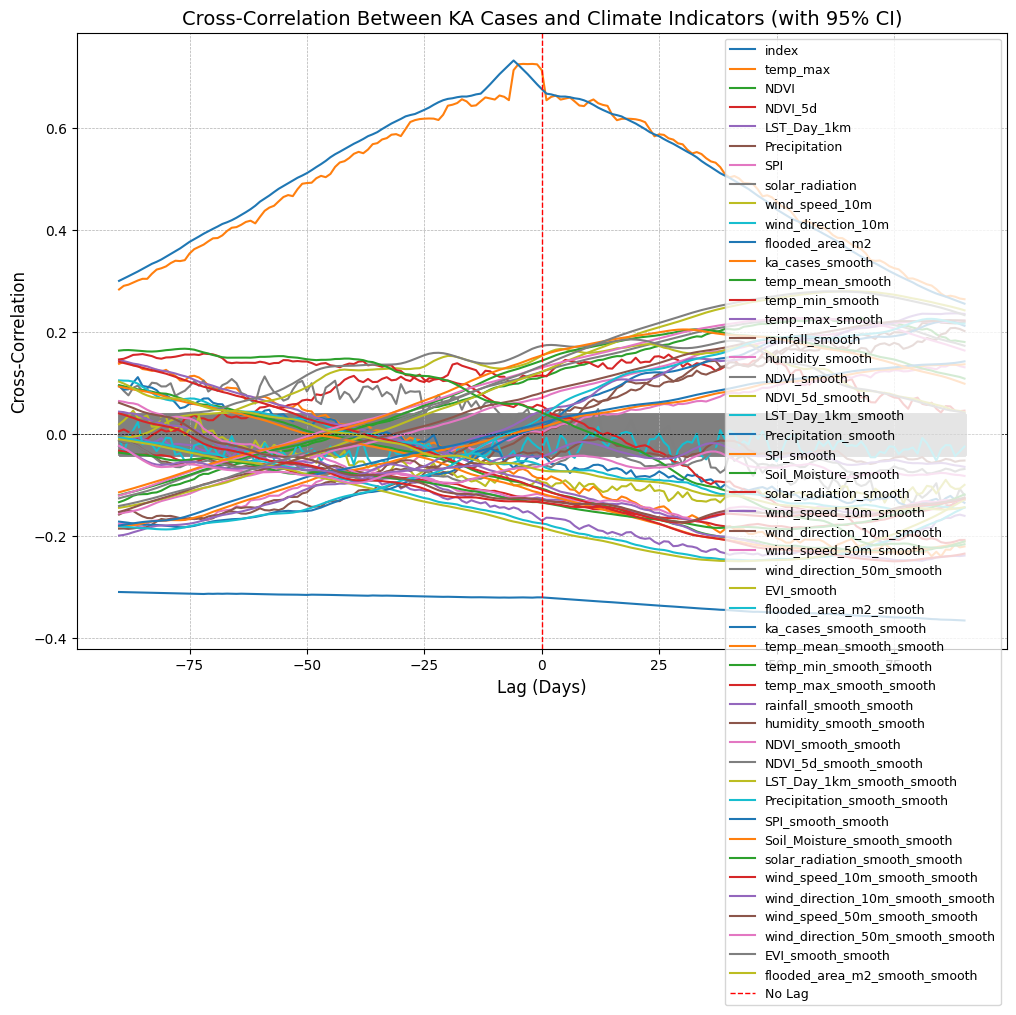

In [50]:
# Statistical Significance of Cross-Correlation (p-values)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Fill missing values (linear interpolation)
merged_df = merged_df.interpolate()

# Normalize KA cases and climate variables
merged_df_normalized = (merged_df - merged_df.mean()) / merged_df.std()

# Define KA case time series
ka_cases_series = merged_df_normalized["ka_cases"]

# Define climate variables to analyze
climate_vars = [col for col in merged_df_normalized.columns if col != "ka_cases"]

# Set max lag in days
max_lag = 90
lags = np.arange(-max_lag, max_lag + 1)

# Create figure
plt.figure(figsize=(12, 8))

for col in climate_vars:
    # Compute cross-correlation at each lag
    cross_corr = [ka_cases_series.corr(merged_df_normalized[col].shift(lag)) for lag in lags]

    # Compute confidence interval (assuming normal distribution)
    n = len(ka_cases_series.dropna())
    ci = 1.96 / np.sqrt(n)  # 95% CI

    # Plot cross-correlation
    plt.plot(lags, cross_corr, label=col)

    # Plot confidence interval bands
    plt.fill_between(lags, -ci, ci, color="gray", alpha=0.2)

# Add reference lines
plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
plt.axvline(0, color="red", linestyle="--", label="No Lag", linewidth=1)

# Labels and legend
plt.xlabel("Lag (Days)", fontsize=12)
plt.ylabel("Cross-Correlation", fontsize=12)
plt.title("Cross-Correlation Between KA Cases and Climate Indicators (with 95% CI)", fontsize=14)
plt.legend(loc="upper right", fontsize=9)
plt.grid(True, linestyle="--", linewidth=0.5)

# Show plot
plt.show()

## Top 20 predictors 

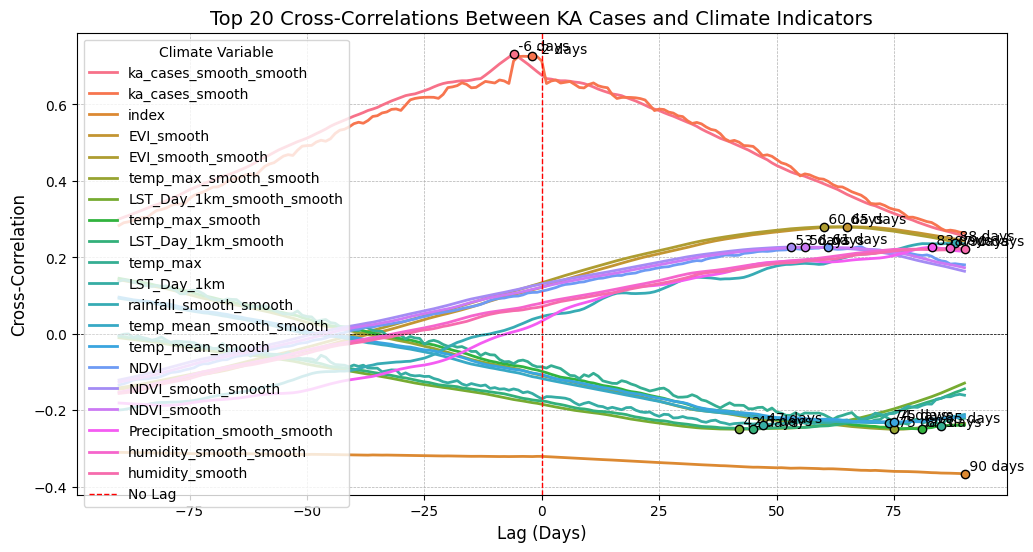

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fill missing values
merged_df = merged_df.interpolate()

# Normalize KA cases and climate variables
merged_df_normalized = (merged_df - merged_df.mean()) / merged_df.std()

# Define KA case time series
ka_cases_series = merged_df_normalized["ka_cases"]

# Define climate variables
climate_vars = [col for col in merged_df_normalized.columns if col != "ka_cases"]

# Set max lag in days
max_lag = 90
lags = np.arange(-max_lag, max_lag + 1)

# Compute cross-correlation for each climate variable
cross_corr_dict = {}
for col in climate_vars:
    cross_corr = [ka_cases_series.corr(merged_df_normalized[col].shift(lag)) for lag in lags]
    cross_corr_dict[col] = cross_corr

# Convert to DataFrame
cross_corr_df = pd.DataFrame(cross_corr_dict, index=lags)

# Select top N variables with highest absolute correlation at any lag
top_n = 20
top_vars = cross_corr_df.abs().max().nlargest(top_n).index

# Visualization
plt.figure(figsize=(12, 6))
colors = sns.color_palette("husl", top_n)

for i, col in enumerate(top_vars):
    plt.plot(lags, cross_corr_df[col], label=col, color=colors[i], linewidth=2)

    # Highlight peak correlation
    peak_lag = lags[np.argmax(np.abs(cross_corr_df[col]))]
    peak_value = cross_corr_df[col].loc[peak_lag]
    plt.scatter(peak_lag, peak_value, color=colors[i], edgecolor="black", zorder=3)
    plt.text(peak_lag, peak_value, f" {peak_lag} days", fontsize=10, verticalalignment="bottom")

# Add reference lines
plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
plt.axvline(0, color="red", linestyle="--", label="No Lag", linewidth=1)

# Labels and legend
plt.xlabel("Lag (Days)", fontsize=12)
plt.ylabel("Cross-Correlation", fontsize=12)
plt.title(f"Top {top_n} Cross-Correlations Between KA Cases and Climate Indicators", fontsize=14)
plt.legend(title="Climate Variable", fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5)

# Show plot
plt.show()


# Normalise the KA and climate varibales 

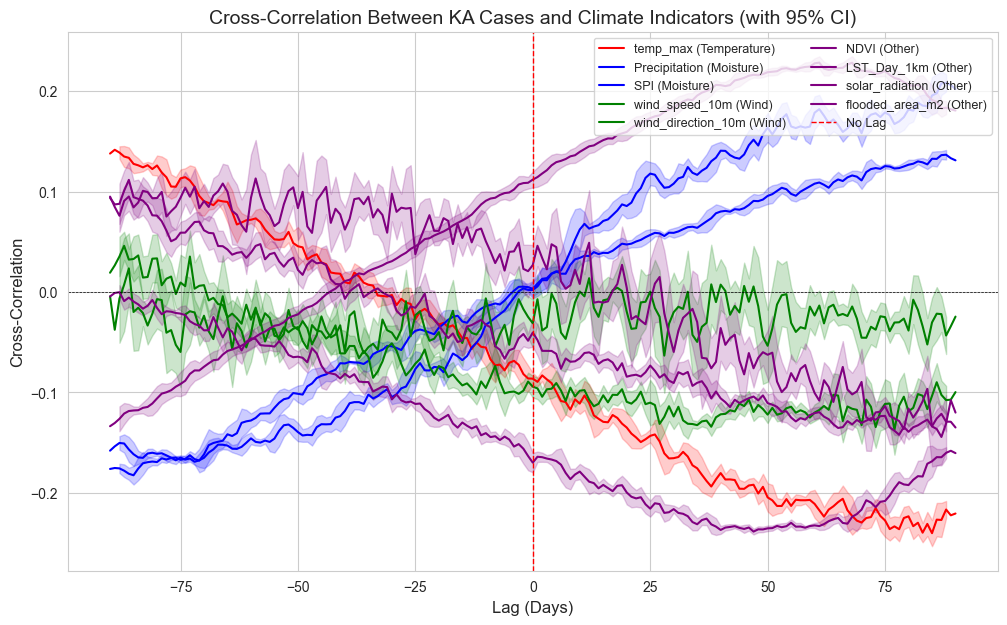

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure date is a datetime index

# Normalize KA cases and climate variables
merged_df_normalized = (merged_df - merged_df.mean()) / merged_df.std()

# Define the KA case time series
ka_cases_series = merged_df_normalized["ka_cases"]

# Define climate variable groups
grouped_vars = {
    "Temperature": ["temp_mean", "temp_max"],
    "Moisture": ["Precipitation", "SPI"],
    "Wind": ["wind_speed_10m", "wind_direction_10m"],
    "Other": ["NDVI", "LST_Day_1km", "solar_radiation", "flooded_area_m2"]
}

# Set max lag in days
max_lag = 90
lags = np.arange(-max_lag, max_lag + 1)

# Initialize figure
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Color mapping for groups
colors = {"Temperature": "red", "Moisture": "blue", "Wind": "green", "Other": "purple"}

for group, variables in grouped_vars.items():
    for var in variables:
        if var in merged_df_normalized.columns:
            # Compute cross-correlation
            cross_corr = [ka_cases_series.corr(merged_df_normalized[var].shift(lag)) for lag in lags]
            
            # Compute rolling standard deviation for CI
            cross_corr_series = pd.Series(cross_corr)
            ci = cross_corr_series.rolling(5, center=True).std() * 1.96  # 95% CI

            # Plot cross-correlation with shading for CI
            plt.plot(lags, cross_corr, label=f"{var} ({group})", color=colors[group])
            plt.fill_between(lags, cross_corr - ci, cross_corr + ci, color=colors[group], alpha=0.2)

# Add reference lines
plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
plt.axvline(0, color="red", linestyle="--", label="No Lag", linewidth=1)

# Labels and legend
plt.xlabel("Lag (Days)", fontsize=12)
plt.ylabel("Cross-Correlation", fontsize=12)
plt.title("Cross-Correlation Between KA Cases and Climate Indicators (with 95% CI)", fontsize=14)
plt.legend(loc="upper right", fontsize=9, ncol=2, frameon=True)
plt.show()


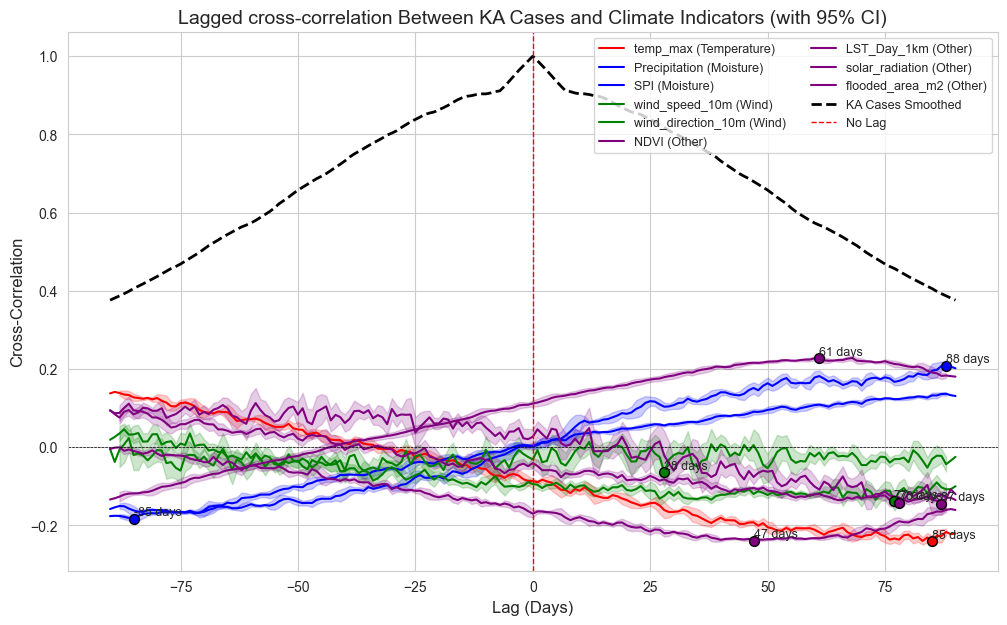

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Normalize KA cases and climate variables
merged_df_normalized = (merged_df - merged_df.mean()) / merged_df.std()

# Define the KA case time series (raw and smoothed)
ka_cases_series = merged_df_normalized["ka_cases"]
ka_cases_smoothed = merged_df_normalized["ka_cases_smooth"]

# Define climate variable groups
grouped_vars = {
    "Temperature": ["temp_mean", "temp_max"],
    "Moisture": ["Precipitation", "SPI"],
    "Wind": ["wind_speed_10m", "wind_direction_10m"],
    "Other": ["NDVI", "LST_Day_1km", "solar_radiation","flooded_area_m2"]
}

# Set max lag in days
max_lag = 90
lags = np.arange(-max_lag, max_lag + 1)

# Initialize figure
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Color mapping for groups
colors = {"Temperature": "red", "Moisture": "blue", "Wind": "green", "Other": "purple"}

# Dictionary to store max cross-correlation lags
max_lags = {}

for group, variables in grouped_vars.items():
    for var in variables:
        if var in merged_df_normalized.columns:
            # Compute cross-correlation
            cross_corr = [ka_cases_series.corr(merged_df_normalized[var].shift(lag)) for lag in lags]
            
            # Compute rolling standard deviation for CI
            cross_corr_series = pd.Series(cross_corr)
            ci = cross_corr_series.rolling(5, center=True).std() * 1.96  # 95% CI

            # Plot cross-correlation with shading for CI
            plt.plot(lags, cross_corr, label=f"{var} ({group})", color=colors[group])
            plt.fill_between(lags, cross_corr - ci, cross_corr + ci, color=colors[group], alpha=0.2)

            # Find the lag with max absolute correlation
            max_lag_idx = np.argmax(np.abs(cross_corr))
            max_lag_day = lags[max_lag_idx]
            max_correlation = cross_corr[max_lag_idx]
            
            # Store significant lags
            max_lags[var] = (max_lag_day, max_correlation)

            # Add dot annotation for max cross-correlation
            plt.scatter(max_lag_day, max_correlation, color=colors[group], edgecolors="black", s=50, zorder=3)
            plt.text(max_lag_day, max_correlation, f"{max_lag_day} days", fontsize=9, verticalalignment="bottom")

# Plot smoothed KA cases
plt.plot(lags, [ka_cases_smoothed.corr(ka_cases_smoothed.shift(lag)) for lag in lags], 
         linestyle="dashed", color="black", label="KA Cases Smoothed", linewidth=2)

# Add reference lines
plt.axhline(0, color="black", linestyle="--", linewidth=0.5)
plt.axvline(0, color="red", linestyle="--", label="No Lag", linewidth=1)

# Labels and legend
plt.xlabel("Lag (Days)", fontsize=12)
plt.ylabel("Cross-Correlation", fontsize=12)
plt.title("Lagged cross-correlation Between KA Cases and Climate Indicators (with 95% CI)", fontsize=14)
plt.legend(loc="upper right", fontsize=9, ncol=2, frameon=True)
plt.show()


## Granger test

In [55]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Define max lag for testing
max_lag = 90

# Drop missing values (ensure data integrity)
merged_df = merged_df.dropna()

# Dictionary to store results
granger_results = {}

# Run Granger causality test for each climate variable
for col in climate_vars:
    try:
        test_result = grangercausalitytests(merged_df[["ka_cases", col]], max_lag, verbose=False)
        p_values = [test_result[i+1][0]['ssr_chi2test'][1] for i in range(max_lag)]
        
        # Find the best lag (lowest p-value)
        min_p_value = min(p_values)
        best_lag = np.argmin(p_values) + 1  # Convert to 1-based index
        
        granger_results[col] = (best_lag, min_p_value)
    
    except Exception as e:
        print(f"Skipping {col} due to error: {e}")

# Convert results to DataFrame
granger_df = pd.DataFrame(granger_results, index=["Best Lag (Days)", "P-value"]).T

# Sort results (first by p-value, then by best lag)
granger_df.sort_values(["P-value", "Best Lag (Days)"], ascending=[True, True], inplace=True)

# Display results
print(granger_df)

# Highlight significant results (p < 0.05)
significant_vars = granger_df[granger_df["P-value"] < 0.05]
print("\nSignificant Climate Variables Influencing KA Cases (p < 0.05):")
print(significant_vars)


                                  Best Lag (Days)        P-value
ka_cases_smooth                               6.0  4.960183e-209
ka_cases_smooth_smooth                        6.0  9.344766e-185
index                                         1.0   5.636836e-22
LST_Day_1km_smooth_smooth                     1.0   7.118753e-08
LST_Day_1km_smooth                            1.0   3.856811e-07
NDVI_5d_smooth_smooth                         1.0   5.723916e-07
NDVI_5d_smooth                                1.0   3.968329e-06
Soil_Moisture_smooth_smooth                   1.0   5.501400e-06
LST_Day_1km                                   1.0   7.475182e-06
EVI_smooth_smooth                             2.0   8.515906e-06
flooded_area_m2_smooth_smooth                35.0   1.390273e-05
flooded_area_m2_smooth                       36.0   1.608005e-05
Soil_Moisture_smooth                          1.0   2.033535e-05
EVI_smooth                                    2.0   3.697396e-05
rainfall_smooth          

## GCT with stationaity control and differeincig 

                                  Best Lag (Days)       P-value
ka_cases_smooth                               1.0  6.619015e-69
ka_cases_smooth_smooth                       12.0  2.076554e-58
NDVI_5d_smooth_smooth                        90.0  4.317663e-14
Precipitation_smooth_smooth                  90.0  1.871657e-13
flooded_area_m2_smooth_smooth                89.0  1.858965e-10
flooded_area_m2_smooth                       81.0  1.105257e-08
Soil_Moisture_smooth_smooth                  90.0  2.326759e-08
flooded_area_m2                              49.0  1.495184e-07
Precipitation_smooth                         90.0  2.063249e-07
NDVI_smooth_smooth                           87.0  3.006488e-07
Soil_Moisture_smooth                         90.0  6.358586e-07
rainfall_smooth_smooth                       89.0  7.765888e-07
rainfall_smooth                              89.0  8.579911e-07
solar_radiation_smooth_smooth                86.0  2.664601e-05
NDVI_5d_smooth                          

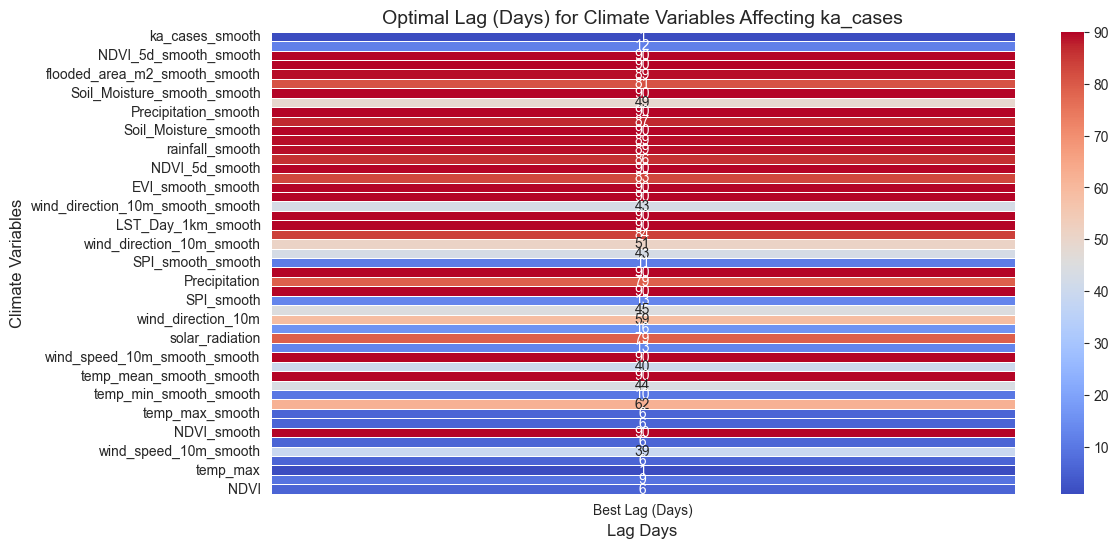

In [56]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Ensure 'date' column is set as the index (if applicable)
if 'date' in merged_df.columns:
    merged_df = merged_df.set_index('date')

# Remove duplicate indices if they exist
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

# Function to check stationarity (You need to define 'check_stationarity' function if not already)
def check_stationarity(series):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(series.dropna())  # Drop NaNs before test
    return result[1] < 0.05  # Returns True if the series is stationary

# Apply differencing if needed
for col in ["ka_cases"] + climate_vars:
    if not check_stationarity(merged_df[col]):
        merged_df[col] = merged_df[col].diff()  # First difference to remove trend

# Drop NaN values introduced by differencing
merged_df.dropna(inplace=True)

# Define max lag
max_lag = 90

# Dictionary to store results
granger_results = {}

# Run Granger causality test for each climate variable
for col in climate_vars:
    test_result = grangercausalitytests(merged_df[["ka_cases", col]], max_lag, verbose=False)
    p_values = [test_result[i+1][0]['ssr_chi2test'][1] for i in range(max_lag)]
    
    # Find the lag with the smallest p-value
    min_p_value = min(p_values)
    best_lag = np.argmin(p_values) + 1  # Convert to 1-based index
    
    granger_results[col] = (best_lag, min_p_value)

# Convert results to DataFrame
granger_df = pd.DataFrame(granger_results, index=["Best Lag (Days)", "P-value"]).T
granger_df.sort_values("P-value", inplace=True)

# Display the results
print(granger_df)

# Visualization - Heatmap of Best Lags
plt.figure(figsize=(12, 6))
sns.heatmap(granger_df[["Best Lag (Days)"]], annot=True, cmap="coolwarm", linewidths=0.5, cbar=True)

# Titles and labels
plt.title("Optimal Lag (Days) for Climate Variables Affecting ka_cases", fontsize=14)
plt.xlabel("Lag Days", fontsize=12)
plt.ylabel("Climate Variables", fontsize=12)

# Show the heatmap
plt.show()


## Log p value 

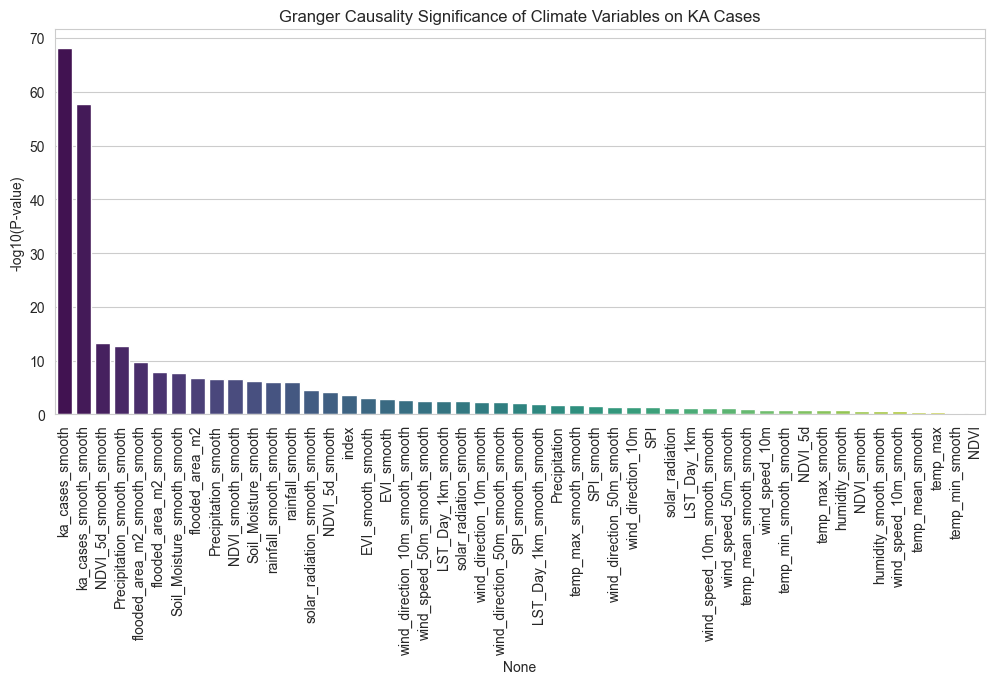

In [57]:
import numpy as np

# Convert p-values to -log10 scale for better visualization
granger_df['log_p_value'] = -np.log10(granger_df['P-value'])

plt.figure(figsize=(12, 5))
sns.barplot(x=granger_df.index, y=granger_df['log_p_value'], palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("-log10(P-value)")
plt.title("Granger Causality Significance of Climate Variables on KA Cases")
plt.show()


1️⃣ Confirm Stationarity (Dickey-Fuller Test)
Before trusting Granger results, ensure both KA cases and climate variables are stationary.

In [58]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1]  # p-value

# Check for stationarity in KA cases and significant climate variables
for col in ["ka_cases"] + list(significant_vars.index):
    p_val = check_stationarity(merged_df[col])
    print(f"{col}: ADF p-value = {p_val:.5f} {'(Stationary)' if p_val < 0.05 else '(Not Stationary)'}")


ka_cases: ADF p-value = 0.00000 (Stationary)
ka_cases_smooth: ADF p-value = 0.00000 (Stationary)
ka_cases_smooth_smooth: ADF p-value = 0.00000 (Stationary)
index: ADF p-value = 0.00073 (Stationary)
LST_Day_1km_smooth_smooth: ADF p-value = 0.00552 (Stationary)
LST_Day_1km_smooth: ADF p-value = 0.00857 (Stationary)
NDVI_5d_smooth_smooth: ADF p-value = 0.00001 (Stationary)
NDVI_5d_smooth: ADF p-value = 0.00000 (Stationary)
Soil_Moisture_smooth_smooth: ADF p-value = 0.00605 (Stationary)
LST_Day_1km: ADF p-value = 0.01112 (Stationary)
EVI_smooth_smooth: ADF p-value = 0.00001 (Stationary)
flooded_area_m2_smooth_smooth: ADF p-value = 0.01134 (Stationary)
flooded_area_m2_smooth: ADF p-value = 0.00000 (Stationary)
Soil_Moisture_smooth: ADF p-value = 0.01931 (Stationary)
EVI_smooth: ADF p-value = 0.00026 (Stationary)
rainfall_smooth: ADF p-value = 0.00077 (Stationary)
rainfall_smooth_smooth: ADF p-value = 0.00383 (Stationary)
temp_min_smooth_smooth: ADF p-value = 0.00182 (Stationary)
wind_speed_

2️⃣ Visualizing Lag Effects 📊
Plot the Granger-causal climate variables against KA cases with the best lags.

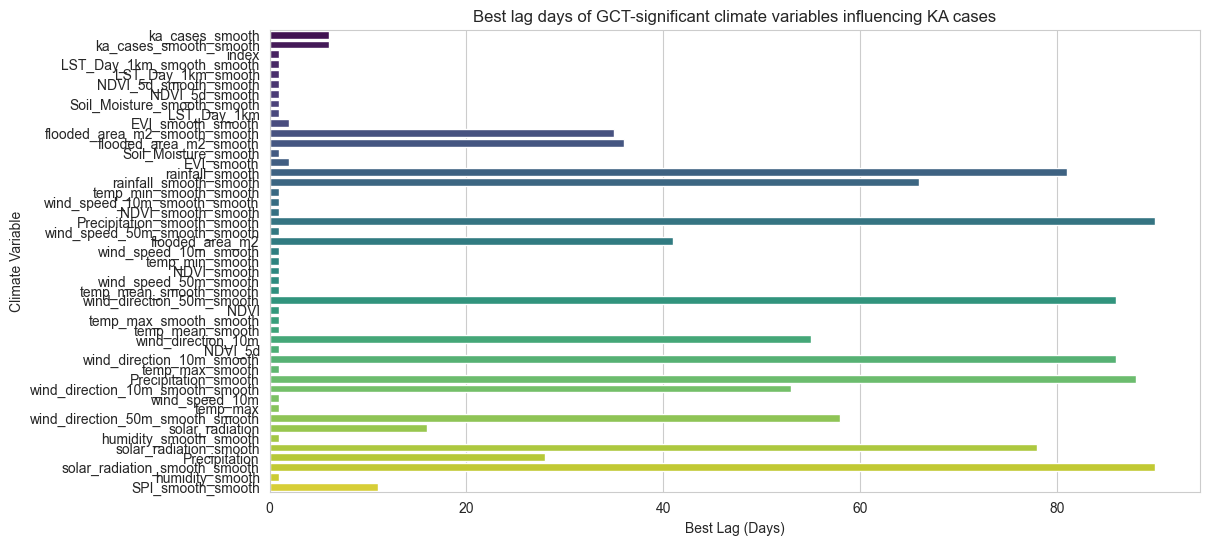

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot significant variables
plt.figure(figsize=(12, 6))
sns.barplot(y=significant_vars.index, x=significant_vars["Best Lag (Days)"], palette="viridis")
plt.xlabel("Best Lag (Days)")
plt.ylabel("Climate Variable")
plt.title("Best lag days of GCT-significant climate variables influencing KA cases")
plt.show()


# Fourier seasonality 

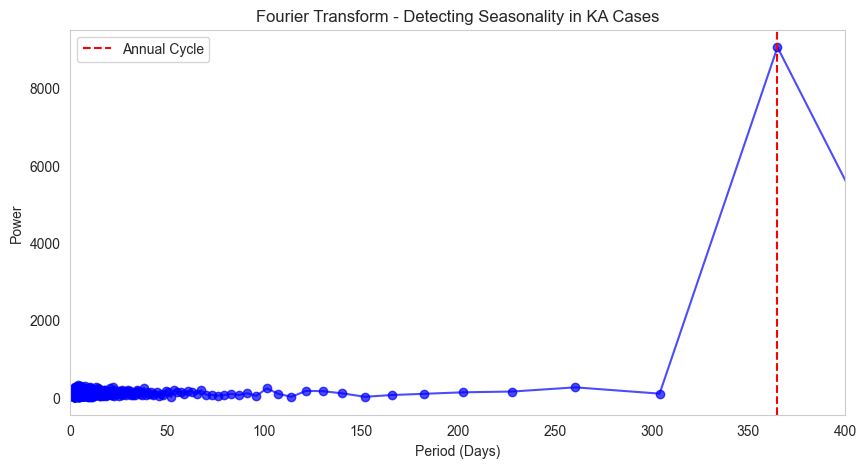

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

# Load your KA cases time-series data (assumed format: 'date' and 'cases')
df = merged_df

# Simulating a KA cases time series for demonstration
np.random.seed(42)
date_range = pd.date_range(start='2015-01-01', periods=365*5, freq='D')  # 5 years of daily data
cases = 50 + 10 * np.sin(2 * np.pi * date_range.dayofyear / 365) + np.random.normal(0, 3, len(date_range))
df = pd.DataFrame({'date': date_range, 'cases': cases})
df.set_index('date', inplace=True)

# Apply FFT to the KA cases data
y = df['cases'].values
n = len(y)
fft_values = fft(y)  # Compute the Fast Fourier Transform
frequencies = fftfreq(n, d=1)  # Frequency bins (assuming daily data, d=1 day)

# Convert to absolute power spectrum
power_spectrum = np.abs(fft_values[:n//2])  # Take only positive frequencies
frequencies = frequencies[:n//2]

# Plot the power spectrum
plt.figure(figsize=(10, 5))
plt.plot(1/frequencies, power_spectrum, 'bo-', alpha=0.7)
plt.xlim(0, 400)  # Focus on lower frequencies
plt.xlabel("Period (Days)")
plt.ylabel("Power")
plt.title("Fourier Transform - Detecting Seasonality in KA Cases")
plt.axvline(x=365, color='r', linestyle='--', label='Annual Cycle')  # Highlight yearly pattern
plt.legend()
plt.grid()
plt.show()


### Decompose the time series 

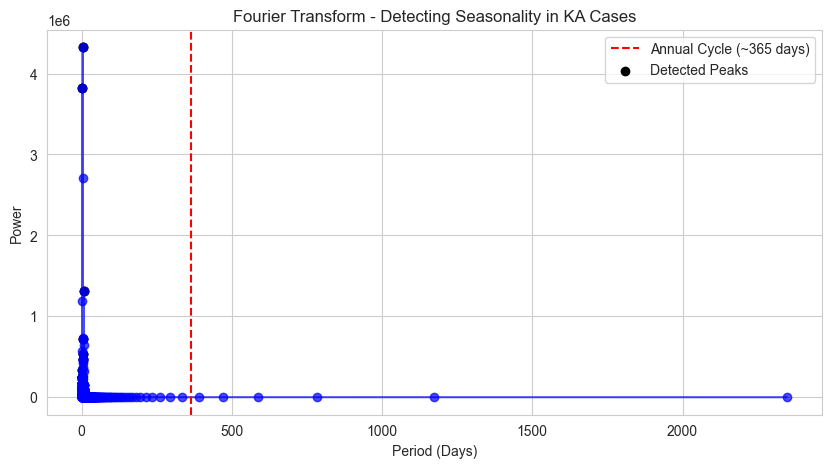

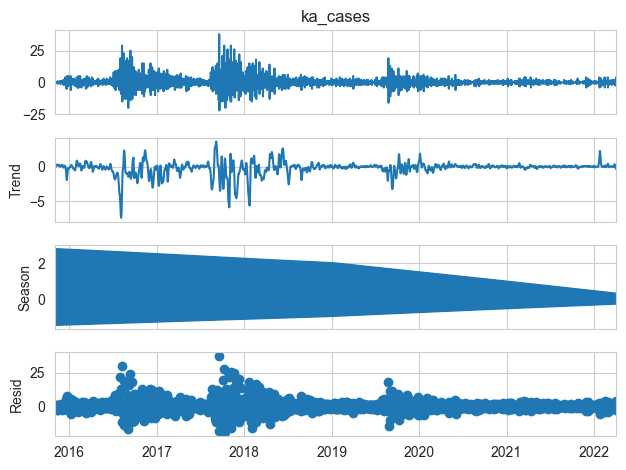

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from scipy.signal import find_peaks

# Load your KA cases data (replace with your actual dataset)

ka_cases = merged_df["ka_cases"]

# Apply Fast Fourier Transform (FFT)
n = len(ka_cases)
freqs = np.fft.fftfreq(n)
fft_values = np.fft.fft(ka_cases)

# Compute power spectrum
power = np.abs(fft_values) ** 2
periods = 1 / np.abs(freqs)  # Convert frequency to period (days)

# Find peaks in power spectrum
peaks, _ = find_peaks(power, height=np.percentile(power, 90))  # Peaks above 90th percentile

# Plot Power Spectrum
plt.figure(figsize=(10, 5))
plt.plot(periods[:n//2], power[:n//2], "b-", marker="o", alpha=0.7)
plt.axvline(x=365, color="red", linestyle="dashed", label="Annual Cycle (~365 days)")
plt.scatter(periods[peaks], power[peaks], color="black", label="Detected Peaks")
plt.xlabel("Period (Days)")
plt.ylabel("Power")
plt.title("Fourier Transform - Detecting Seasonality in KA Cases")
plt.legend()
plt.show()

# Perform Seasonal-Trend Decomposition using STL
stl = STL(ka_cases, seasonal=365, robust=True)
result = stl.fit()

# Plot decomposition
result.plot()
plt.show()


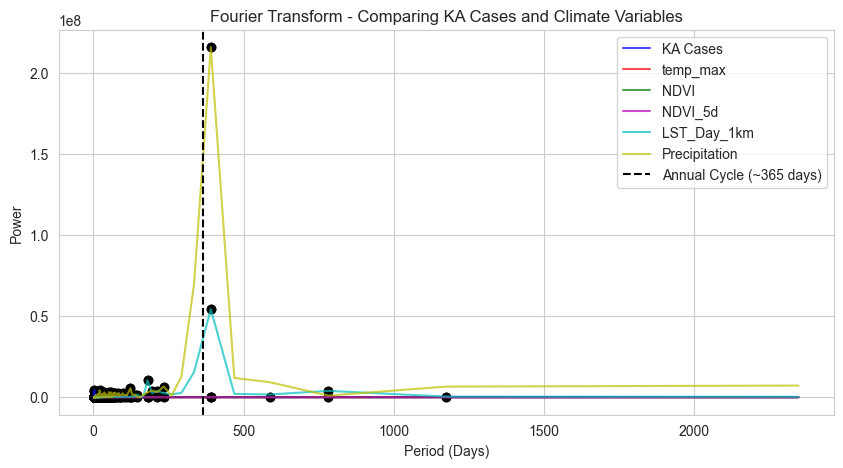

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from statsmodels.tsa.seasonal import STL

# Load KA cases and climate data (Ensure time-series format)
df = merged_df

# Select KA cases and key climate variables
ka_cases = df["ka_cases"]
climate_vars = ['temp_max', 'NDVI', 'NDVI_5d', 'LST_Day_1km', 'Precipitation', 'SPI', 'solar_radiation', 'wind_speed_10m','wind_direction_10m']  # Update as needed

# Function to compute Fourier Transform and plot power spectrum
def fourier_analysis(series, label, color):
    n = len(series)
    freqs = np.fft.fftfreq(n)
    fft_values = np.fft.fft(series)

    power = np.abs(fft_values) ** 2
    periods = 1 / np.abs(freqs)  # Convert frequency to period (days)

    peaks, _ = find_peaks(power, height=np.percentile(power, 90))  # Find dominant cycles

    plt.plot(periods[:n//2], power[:n//2], color, label=label, alpha=0.7)
    plt.scatter(periods[peaks], power[peaks], color="black")

# Plot Fourier Transform for KA Cases
plt.figure(figsize=(10, 5))
fourier_analysis(ka_cases, "KA Cases", "b-")

# Compare with climate variables
colors = ["r-", "g-", "m-", "c-", "y-"]
for var, color in zip(climate_vars, colors):
    fourier_analysis(df[var], var, color)

plt.axvline(x=365, color="black", linestyle="dashed", label="Annual Cycle (~365 days)")
plt.xlabel("Period (Days)")
plt.ylabel("Power")
plt.title("Fourier Transform - Comparing KA Cases and Climate Variables")
plt.legend()
plt.show()


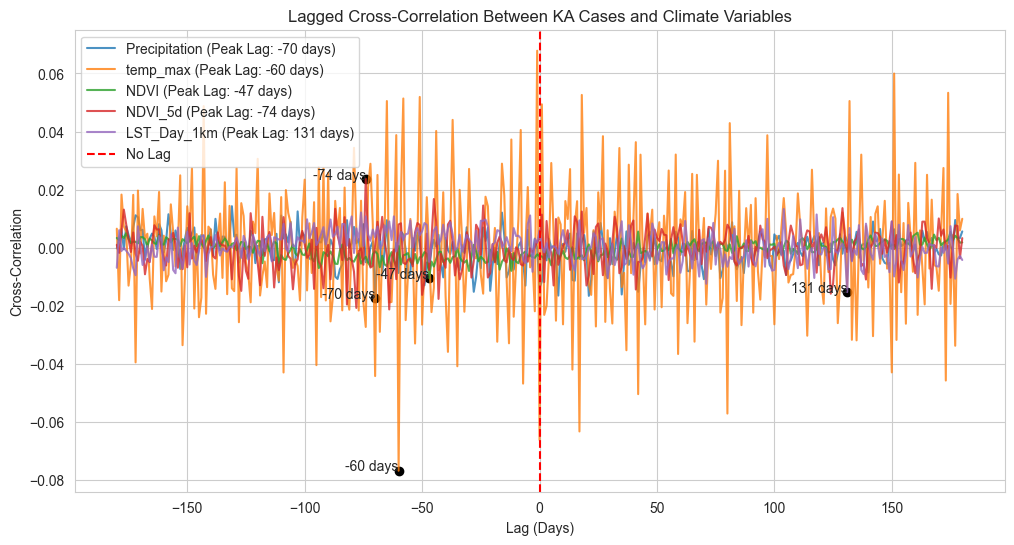

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import ccf

# Load data (ensure date is the index)
df = merged_df

# Select KA cases and key climate variables
ka_cases = df["ka_cases"].dropna()
climate_vars = ["Precipitation", "temp_max", "NDVI", "NDVI_5d", "LST_Day_1km"]  # Update as needed

# Define max lag range (e.g., ±100 days)
max_lag = 180
lags = np.arange(-max_lag, max_lag + 1)

# Plot settings
plt.figure(figsize=(12, 6))

for var in climate_vars:
    # Remove NaNs and align data
    climate_series = df[var].dropna()
    common_idx = ka_cases.index.intersection(climate_series.index)
    
    # Compute cross-correlation function
    ccf_values = ccf(ka_cases.loc[common_idx], climate_series.loc[common_idx])[:2*max_lag+1]
    
    # Find peak lag
    peak_lag = lags[np.argmax(np.abs(ccf_values))]
    peak_corr = ccf_values[np.argmax(np.abs(ccf_values))]
    
    # Plot cross-correlation
    plt.plot(lags, ccf_values, label=f"{var} (Peak Lag: {peak_lag} days)", alpha=0.8)

    # Mark peak point
    plt.scatter(peak_lag, peak_corr, color="black", marker="o")
    plt.text(peak_lag, peak_corr, f"{peak_lag} days", fontsize=10, ha="right")

# Plot zero lag line
plt.axvline(0, linestyle="dashed", color="red", label="No Lag")
plt.xlabel("Lag (Days)")
plt.ylabel("Cross-Correlation")
plt.title("Lagged Cross-Correlation Between KA Cases and Climate Variables")
plt.legend()
plt.show()


Precipitation: Peak correlation at lag 10 is NOT statistically significant.
temp_max: Peak correlation at lag 20 is NOT statistically significant.
NDVI: Peak correlation at lag 33 is NOT statistically significant.
NDVI_5d: Peak correlation at lag 6 is NOT statistically significant.
LST_Day_1km: Peak correlation at lag 4 is NOT statistically significant.


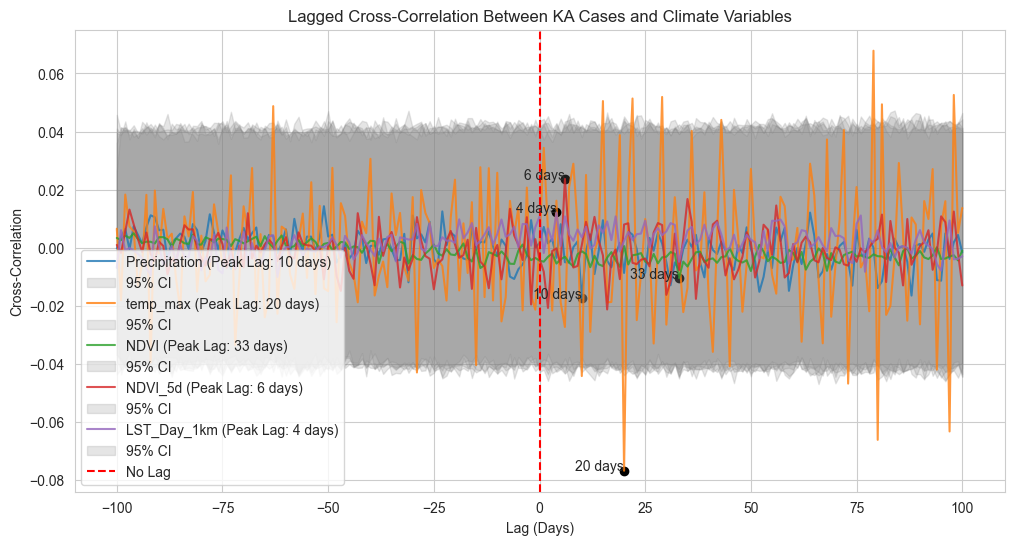

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import ccf

# Load data (ensure 'date' is the index)
df = merged_df

# Select KA cases and key climate variables
ka_cases = df["ka_cases"].dropna()
climate_vars = ["Precipitation", "temp_max", "NDVI", "NDVI_5d", "LST_Day_1km"]  # Update as needed

# Define max lag range (e.g., ±100 days)
max_lag = 100
lags = np.arange(-max_lag, max_lag + 1)

# Number of bootstrap iterations for confidence interval
bootstrap_iter = 1000

# Plot settings
plt.figure(figsize=(12, 6))

for var in climate_vars:
    # Remove NaNs and align data
    climate_series = df[var].dropna()
    common_idx = ka_cases.index.intersection(climate_series.index)  # Align indices
    
    # Check if there is enough data
    if len(common_idx) > 0:
        # Compute original cross-correlation function
        ccf_values = ccf(ka_cases.loc[common_idx], climate_series.loc[common_idx])[:2*max_lag+1]
        
        # Bootstrap for confidence intervals
        bootstrap_ccf = np.zeros((bootstrap_iter, 2*max_lag + 1))
        for i in range(bootstrap_iter):
            # Resample with replacement for bootstrap
            bootstrap_sample = np.random.choice(common_idx, size=len(common_idx), replace=True)
            bootstrap_ka_cases = ka_cases.loc[bootstrap_sample]
            bootstrap_climate_series = climate_series.loc[bootstrap_sample]
            
            # Compute the CCF for the bootstrap sample
            bootstrap_ccf[i, :] = ccf(bootstrap_ka_cases, bootstrap_climate_series)[:2*max_lag+1]
        
        # Compute the 95% confidence intervals
        lower_bound = np.percentile(bootstrap_ccf, 2.5, axis=0)
        upper_bound = np.percentile(bootstrap_ccf, 97.5, axis=0)
        
        # Find peak lag
        peak_lag = lags[np.argmax(np.abs(ccf_values))]
        peak_corr = ccf_values[np.argmax(np.abs(ccf_values))]
        
        # Plot cross-correlation with confidence intervals
        plt.plot(lags, ccf_values, label=f"{var} (Peak Lag: {peak_lag} days)", alpha=0.8)
        plt.fill_between(lags, lower_bound, upper_bound, color="gray", alpha=0.2, label="95% CI")
        
        # Mark peak point
        plt.scatter(peak_lag, peak_corr, color="black", marker="o")
        plt.text(peak_lag, peak_corr, f"{peak_lag} days", fontsize=10, ha="right")
        
        # Test for significance at peak lag
        if np.abs(peak_corr) > np.abs(lower_bound[peak_lag + max_lag]) and np.abs(peak_corr) < np.abs(upper_bound[peak_lag + max_lag]):
            print(f"{var}: Peak correlation at lag {peak_lag} is statistically significant!")
        else:
            print(f"{var}: Peak correlation at lag {peak_lag} is NOT statistically significant.")
    else:
        print(f"Not enough data for {var} and KA_cases")

# Plot zero lag line
plt.axvline(0, linestyle="dashed", color="red", label="No Lag")
plt.xlabel("Lag (Days)")
plt.ylabel("Cross-Correlation")
plt.title("Lagged Cross-Correlation Between KA Cases and Climate Variables")
plt.legend()
plt.show()


Interpreting the Results:
The plot will show the cross-correlation function for each climate variable at different lags.
The gray shaded region represents the 95% confidence interval for the cross-correlation under the null hypothesis (no relationship).
If the cross-correlation exceeds this confidence interval, it indicates a significant relationship at that particular lag.


### Granger Causality Test for fourrier 

In [65]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Load your data (ensure 'date' is the index)
df = merged_df

# Select KA cases and key climate variables
ka_cases = df["ka_cases"].dropna()
climate_vars = ["Precipitation", "temp_max", "NDVI", "NDVI_5d", "LST_Day_1km"]  # Update as needed

# Define the maximum number of lags to test
max_lag = 30  # Adjust based on the dataset frequency and what you think is appropriate

# Perform the Granger Causality test for each climate variable
for var in climate_vars:
    # Remove NaNs and align data
    climate_series = df[var].dropna()
    common_idx = ka_cases.index.intersection(climate_series.index)  # Align indices
    
    # Ensure the time series are the same length
    if len(common_idx) > 0:
        # Create a DataFrame for the Granger causality test
        data = pd.DataFrame({'KA_cases': ka_cases.loc[common_idx], var: climate_series.loc[common_idx]})
        
        # Perform Granger Causality Test
        print(f"\nGranger Causality Test between KA cases and {var}:")
        test_result = grangercausalitytests(data, max_lag, verbose=True)
    else:
        print(f"Not enough data for {var} and KA_cases")



Granger Causality Test between KA cases and Precipitation:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0351  , p=0.8514  , df_denom=2343, df_num=1
ssr based chi2 test:   chi2=0.0351  , p=0.8513  , df=1
likelihood ratio test: chi2=0.0351  , p=0.8513  , df=1
parameter F test:         F=0.0351  , p=0.8514  , df_denom=2343, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4081  , p=0.6649  , df_denom=2340, df_num=2
ssr based chi2 test:   chi2=0.8180  , p=0.6643  , df=2
likelihood ratio test: chi2=0.8178  , p=0.6644  , df=2
parameter F test:         F=0.4081  , p=0.6649  , df_denom=2340, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2806  , p=0.8395  , df_denom=2337, df_num=3
ssr based chi2 test:   chi2=0.8442  , p=0.8389  , df=3
likelihood ratio test: chi2=0.8441  , p=0.8389  , df=3
parameter F test:         F=0.2806  , p=0.8395  , df_denom=2337, df_num=3

Granger Causality
number of


Granger Causality Test between KA cases and Precipitation:

Granger Causality Test between KA cases and temp_max:

Granger Causality Test between KA cases and NDVI:

Granger Causality Test between KA cases and NDVI_5d:

Granger Causality Test between KA cases and LST_Day_1km:


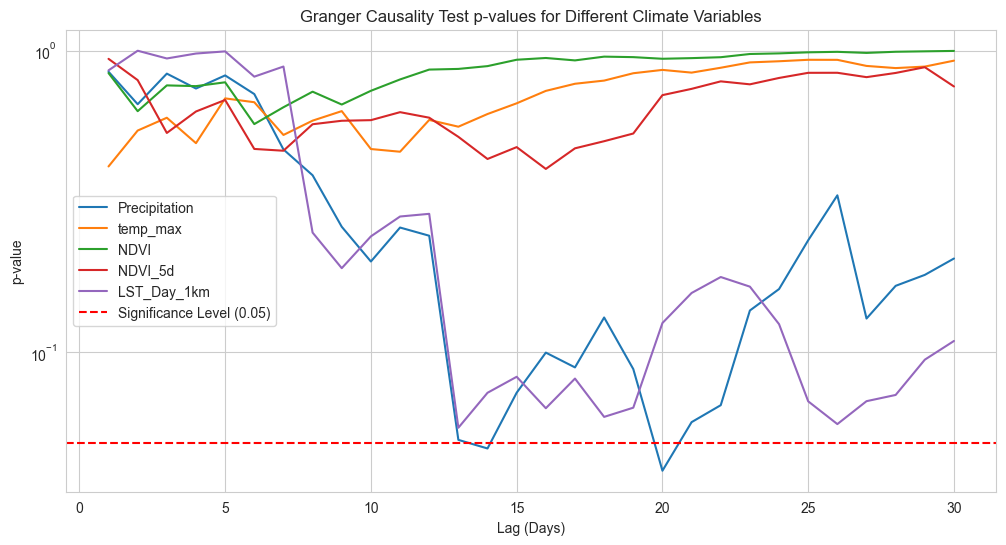

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

# Load your data (ensure 'date' is the index)
df = merged_df

# Select KA cases and key climate variables
ka_cases = df["ka_cases"].dropna()
climate_vars = ["Precipitation", "temp_max", "NDVI", "NDVI_5d", "LST_Day_1km"]  # Update as needed

# Define the maximum number of lags to test
max_lag = 30  # Adjust based on the dataset frequency and what you think is appropriate

# Set up the plot
plt.figure(figsize=(12, 6))

# Loop through each climate variable and perform the Granger causality test
for var in climate_vars:
    # Remove NaNs and align data
    climate_series = df[var].dropna()
    common_idx = ka_cases.index.intersection(climate_series.index)  # Align indices
    
    # Ensure the time series are the same length
    if len(common_idx) > 0:
        # Create a DataFrame for the Granger causality test
        data = pd.DataFrame({'KA_cases': ka_cases.loc[common_idx], var: climate_series.loc[common_idx]})
        
        # Perform Granger Causality Test and collect p-values
        print(f"\nGranger Causality Test between KA cases and {var}:")
        test_result = grangercausalitytests(data, max_lag, verbose=False)
        
        # Collect p-values for each lag
        p_values = []
        for lag in range(1, max_lag + 1):
            p_value = test_result[lag][0]['ssr_chi2test'][1]  # p-value for the chi-squared test
            p_values.append(p_value)
        
        # Plot p-values for each lag
        plt.plot(np.arange(1, max_lag + 1), p_values, label=f"{var}")
    
# Highlight significant p-values
plt.axhline(y=0.05, color='red', linestyle='--', label="Significance Level (0.05)")

# Add plot labels and title
plt.xlabel('Lag (Days)')
plt.ylabel('p-value')
plt.title('Granger Causality Test p-values for Different Climate Variables')
plt.legend()
plt.yscale('log')  # Log scale to make interpretation easier, since p-values can vary over orders of magnitude
plt.show()


Result Interpretation:
Significant Lags: Any p-value below the threshold (0.05) indicates that the climate variable Granger causes KA cases at that particular lag.
Multiple Climate Variables: You will be able to see the p-values for all the climate variables plotted together, allowing you to compare how different climate variables affect KA cases over time.

### Time Series Regression using GLS:

ADF test p-value for KA_cases: 1.1788834873830447e-19
ADF test p-value for Precipitation: 0.0032178416628281465
ADF test p-value for temp_max: 5.3563393013584704e-30
ADF test p-value for NDVI: 0.027593483262278385
ADF test p-value for NDVI_5d: 6.482778517543167e-08
ADF test p-value for LST_Day_1km: 0.011123989845931484
                            OLS Regression Results                            
Dep. Variable:               ka_cases   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.04530
Date:                Fri, 21 Mar 2025   Prob (F-statistic):              0.999
Time:                        03:42:13   Log-Likelihood:                -6534.2
No. Observations:                2347   AIC:                         1.308e+04
Df Residuals:                    2341   BIC:                         1.311e+04
Df Model:                           5          

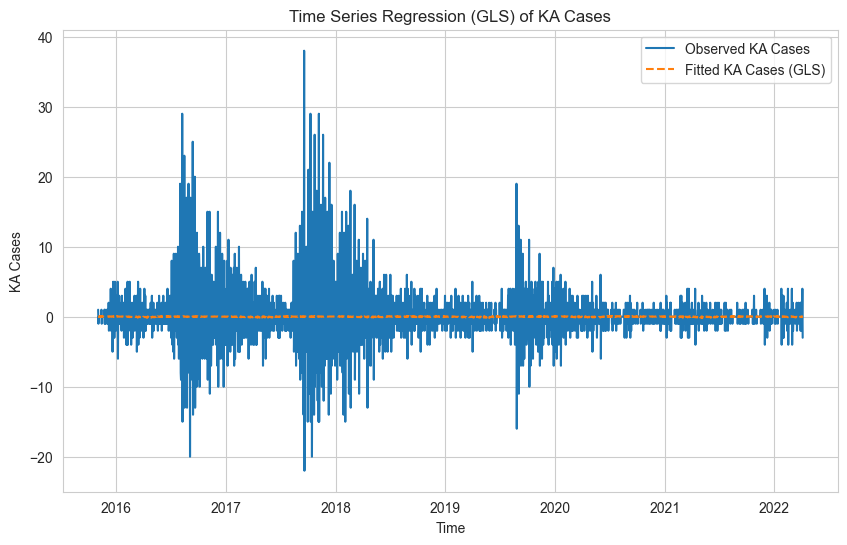

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg

# Load your data (ensure 'date' is the index)
df = merged_df

# Select KA cases and climate variables
ka_cases = df["ka_cases"].dropna()
climate_vars = ["Precipitation", "temp_max", "NDVI", "NDVI_5d", "LST_Day_1km"]  # Adjust as needed

# Check for stationarity of KA_cases (ADF test)
adf_test = adfuller(ka_cases)
print(f"ADF test p-value for KA_cases: {adf_test[1]}")

# Check for stationarity of climate variables
for var in climate_vars:
    adf_test = adfuller(df[var].dropna())
    print(f"ADF test p-value for {var}: {adf_test[1]}")

# Prepare data for GLS
# Assuming we're predicting KA_cases based on climate variables
X = df[climate_vars].dropna()  # Independent variables
y = ka_cases.loc[X.index]  # Dependent variable (KA_cases)

# Add constant to the independent variables (for intercept)
X = sm.add_constant(X)

# Check for autocorrelation and heteroscedasticity in residuals (e.g., using ACF, PACF, or Durbin-Watson test)
# Fit the OLS model first
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

# Residuals of OLS model
residuals = ols_model.resid

# GLS Regression: Use autocorrelation structure (e.g., AR(1) model)
# Fit an AutoReg model (for AR(1) structure)
ar_model = AutoReg(residuals, lags=1)
ar_result = ar_model.fit()

# Extract AR(1) parameter
rho = ar_result.params[1]  # AR(1) coefficient

# Create GLS model with AR(1) error structure
gls_model = sm.GLS(y, X, sigma=np.eye(len(y)) * (1 - rho))  # Adjust sigma matrix for autocorrelation
gls_result = gls_model.fit()

# Print GLS results
print(gls_result.summary())

# Plot the fitted values vs actual
plt.figure(figsize=(10, 6))
plt.plot(y, label="Observed KA Cases")
plt.plot(gls_result.fittedvalues, label="Fitted KA Cases (GLS)", linestyle='--')
plt.legend()
plt.xlabel("Time")
plt.ylabel("KA Cases")
plt.title("Time Series Regression (GLS) of KA Cases")
plt.show()
